In [3]:
# notebooks/generate_datasets.py
import pandas as pd
import numpy as np

# Parameters
cities = ['CityA', 'CityB', 'CityC']
hours = pd.date_range("2025-01-01", "2025-01-07 23:00:00", freq="H")  # 1 week

# Traffic data
traffic_rows = []
for city in cities:
    for ts in hours:
        traffic_volume = np.random.poisson(lam=1000 + 200*np.sin(ts.hour/24*2*np.pi))
        traffic_rows.append([ts, city, traffic_volume])
df_traffic = pd.DataFrame(traffic_rows, columns=['timestamp', 'city', 'traffic_volume'])
df_traffic['lat'] = df_traffic['city'].map({'CityA': 40.0, 'CityB': 41.0, 'CityC': 42.0})
df_traffic['lon'] = df_traffic['city'].map({'CityA': -74.0, 'CityB': -75.0, 'CityC': -76.0})

df_traffic.to_csv('raw/traffic.csv', index=False)

# Air quality data
aq_rows = []
for city in cities:
    for ts in hours:
        pm25 = np.random.normal(30 + 0.01*traffic_rows[0][2], 5)
        no2 = np.random.normal(20 + 0.005*traffic_rows[0][2], 3)
        aqi = np.random.normal(50 + 0.02*traffic_rows[0][2], 10)
        temperature = np.random.normal(20, 5)
        wind_speed = np.random.uniform(0, 5)
        aq_rows.append([ts, city, pm25, no2, aqi, temperature, wind_speed])
df_aq = pd.DataFrame(aq_rows, columns=['timestamp','city','pm25','no2','aqi','temperature','wind_speed'])
df_aq['lat'] = df_aq['city'].map({'CityA': 40.0, 'CityB': 41.0, 'CityC': 42.0})
df_aq['lon'] = df_aq['city'].map({'CityA': -74.0, 'CityB': -75.0, 'CityC': -76.0})

df_aq.to_csv('raw/air_quality.csv', index=False)

print("Synthetic datasets generated in raw/")


Synthetic datasets generated in raw/


/var/folders/zn/vprq1lcn4d5bpqf0btv13x500000gp/T/ipykernel_7115/1889525804.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range("2025-01-01", "2025-01-07 23:00:00", freq="H")  # 1 week


Columns: Index(['city', 'timestamp', 'traffic_volume', 'pm25', 'no2', 'aqi',
       'temperature', 'wind_speed', 'lat', 'lon'],
      dtype='object')
                           timestamp  traffic_volume        pm25         no2  \
count                            504      504.000000  504.000000  504.000000   
mean   2025-01-04 11:30:00.000000256     1000.589286   40.165019   25.202859   
min              2025-01-01 00:00:00      737.000000   25.465404   15.612352   
25%              2025-01-02 17:45:00      868.750000   36.234822   23.198790   
50%              2025-01-04 11:30:00     1002.500000   40.278550   25.243964   
75%              2025-01-06 05:15:00     1132.500000   43.842547   27.175536   
max              2025-01-07 23:00:00     1301.000000   58.095120   33.277845   
std                              NaN      143.572718    5.446933    2.945992   

              aqi  temperature  wind_speed         lat         lon  
count  504.000000   504.000000  504.000000  504.000000  504.

/var/folders/zn/vprq1lcn4d5bpqf0btv13x500000gp/T/ipykernel_7455/240374057.py:25: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/var/folders/zn/vprq1lcn4d5bpqf0btv13x500000gp/T/ipykernel_7455/240374057.py:31: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



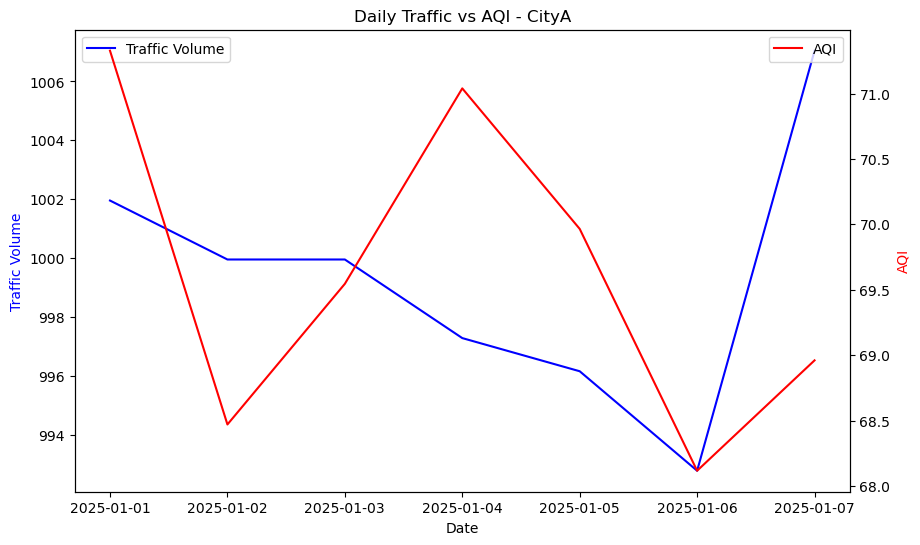

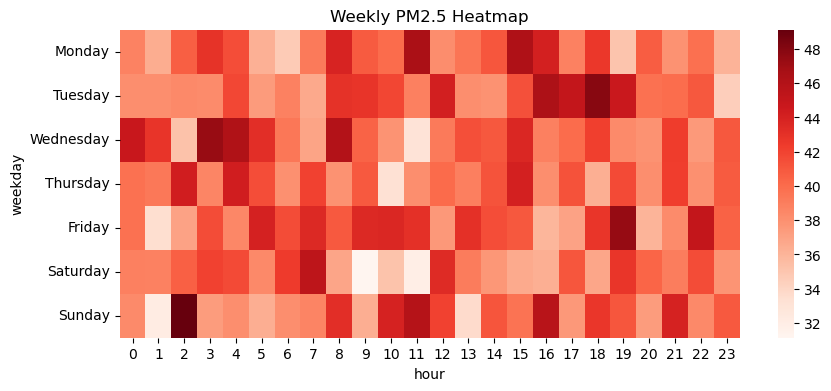

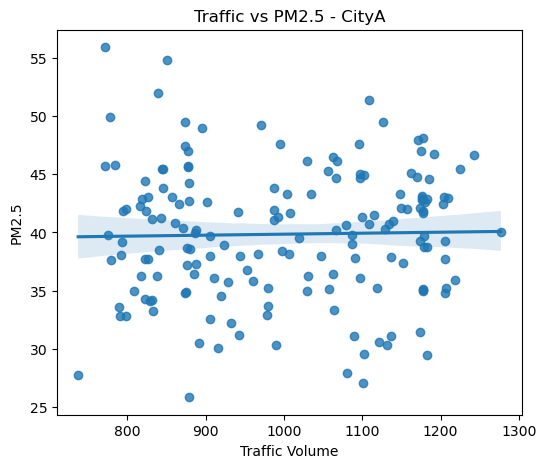

Output is saved as PNG file!


In [3]:
# notebooks/visualization_no_kaleido.ipynb

# --------------------------
# Imports
# --------------------------
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from streamlit_folium import st_folium

# --------------------------
# Load datasets
# --------------------------
df_traffic = pd.read_csv('raw/traffic.csv', parse_dates=['timestamp'])
df_aq = pd.read_csv('raw/air_quality.csv', parse_dates=['timestamp'])

# --------------------------
# Resample traffic (numeric only)
# --------------------------
numeric_traffic = ['traffic_volume']  # numeric columns
t = df_traffic.set_index('timestamp').groupby('city')[numeric_traffic].resample('1H').sum().reset_index()

# --------------------------
# Resample air quality (numeric only)
# --------------------------
numeric_aq = ['pm25','no2','aqi','temperature','wind_speed']
aq = df_aq.set_index('timestamp').groupby('city')[numeric_aq].resample('1H').mean().reset_index()

# --------------------------
# Merge traffic & air quality on nearest timestamp by city
# --------------------------
df = pd.merge_asof(
    t.sort_values('timestamp'),
    aq.sort_values('timestamp'),
    on='timestamp',
    by='city'
)

# --------------------------
# Add lat/lon per city (required for map)
# --------------------------
city_coords = {
    'CityA': (40.0, -74.0),
    'CityB': (41.0, -75.0),
    'CityC': (42.0, -76.0)
}
df['lat'] = df['city'].map(lambda x: city_coords[x][0])
df['lon'] = df['city'].map(lambda x: city_coords[x][1])

# --------------------------
# Save merged dataset
# --------------------------
df.to_csv('data/city_traffic_aqi.csv', index=False)

# --------------------------
# EDA
# --------------------------
print("Columns:", df.columns)
print(df.describe())

# Daily aggregates
df_daily = df.set_index('timestamp').groupby('city')[['traffic_volume','pm25','no2','aqi']].resample('D').mean().reset_index()

# --------------------------
# Visual 1: Dual-axis time series (Matplotlib)
# --------------------------
city = 'CityA'
d = df[df['city']==city].set_index('timestamp')[['traffic_volume','aqi']].resample('D').mean()

fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

ax1.plot(d.index, d['traffic_volume'], color='blue', label='Traffic Volume')
ax2.plot(d.index, d['aqi'], color='red', label='AQI')

ax1.set_xlabel("Date")
ax1.set_ylabel("Traffic Volume", color='blue')
ax2.set_ylabel("AQI", color='red')
plt.title(f"Daily Traffic vs AQI - {city}")

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Save PNG
plt.savefig("images/dual_axis.png")
plt.show()

# --------------------------
# Visual 2: Weekly heatmap (PM2.5)
# --------------------------
df['weekday'] = df['timestamp'].dt.day_name()
df['hour'] = df['timestamp'].dt.hour
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
pivot = df.pivot_table(values='pm25', index='weekday', columns='hour', aggfunc='mean').loc[weekday_order]

plt.figure(figsize=(10,4))
sns.heatmap(pivot, cmap='Reds')
plt.title("Weekly PM2.5 Heatmap")
plt.savefig("images/weekly_pm25_heatmap.png")
plt.show()

# --------------------------
# Visual 3: Scatter + regression (Matplotlib + Seaborn)
# --------------------------
plt.figure(figsize=(6,5))
sns.regplot(x='traffic_volume', y='pm25', data=df[df['city']==city])
plt.xlabel("Traffic Volume")
plt.ylabel("PM2.5")
plt.title(f"Traffic vs PM2.5 - {city}")
plt.savefig("images/scatter_regression.png")
plt.show()

# --------------------------
# Visual 4: Folium map
# --------------------------
lat_center = df['lat'].mean()
lon_center = df['lon'].mean()
m = folium.Map(location=[lat_center, lon_center], zoom_start=6)

for _, row in df[df['city']==city].iterrows():
    folium.CircleMarker(
        [row.lat,row.lon],
        radius=max(3,row['pm25']/5),
        color='red' if row['pm25']>50 else 'green',
        fill=True,
        popup=f"PM2.5: {row.pm25:.1f}\nTraffic: {row.traffic_volume}"
    ).add_to(m)

m.save('images/cityA_pm25_map.html')

print("Output is saved as PNG file!")


In [7]:
conda install -c conda-forge python-kaleido


Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - python-kaleido


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2025.10.5  |       hbd8a1cb_0         152 KB  conda-forge
    certifi-2025.10.5          |     pyhd8ed1ab_0         156 KB  conda-forge
    choreographer-1.1.2        |     pyhcf101f3_0          39 KB  conda-forge
    conda-24.11.3              |  py312h81bd7bf_0         1.1 MB  conda-forge
    libexpat-2.6.3             |       hf9b8971_0          62 KB  conda-forge
    libsqlite-3.46.0           |       hfb93653_0         811 KB  conda-forge
    libzlib-1.2.13             |       hfb2fe0b_6          46 KB  conda-forge
    logistro-2.0.0             |     pyhcf101f3_0          15 KB  conda-forge
    openssl-3.5.4              |       h